In [1]:
import numpy as np # linear algebra
from matplotlib import pyplot as plt
#We need these in this file:
import sys
import pandas as pd
sys.path.append('cropping')
import load_read_name_extractor as lrne
import SVM_classifier_general as svm_general

#Taget fra længere nede i koden:
import torch
from torchvision import transforms
from PIL import Image
import random
import itertools
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score
import DeepFunctions as df
from random import shuffle
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms
from IPython.display import display
import os
import json
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch.nn.functional as F

In [2]:
img_list, names = lrne.load_name_and_img("cropped_mean/*jpeg")

In [3]:
print(len(img_list))
print(len(names))

4915
4915


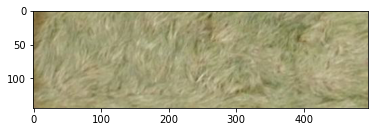

cropped_mean/225_180625_Min.jpeg


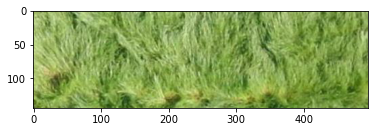

cropped_mean/75_210618_Min.jpeg


In [4]:
# pick a random index
random_index = random.randint(0, len(img_list)-1)

# get the corresponding image and name
random_img = img_list[random_index]
random_name = names[random_index]

# show the image and print the name
plt.imshow(random_img)
plt.show()
print(random_name)

# show the first image and print the name
plt.imshow(img_list[0])
plt.show()
print(names[0])


In [5]:
date_ = False
bin_size = 10
n_bins = int(np.floor(100/bin_size))
labels = svm_general.load_labels(bin_size, date_)
print(labels[0])
print(len(labels))

#convert names into [flight_folder, ROI]
names_labels = lrne.it_name_extract_labels_from_img_jpeg(names)
print(names_labels[0])
lodging_score = [[] for _ in range(4915)]

#match labels with feature names
lodging_score = svm_general.match_pic_label_to_names_new(lodging_score, labels, names_labels, date_)

['139' '5' '190528_Min' '0']
4936
['75', '210618_Min']


In [6]:
lodging_score_int = [[int(char) for char in sublist] for sublist in lodging_score]
flattened_list = list(itertools.chain.from_iterable(lodging_score_int))
#print(flattened_list)
lodging_score = flattened_list
#print(max(lodging_score_int))
count_9 = lodging_score.count(9)
print(count_9)

print(np.shape(img_list))
print(np.shape(flattened_list))

1
(4915, 144, 496, 3)
(4915,)


# Remember to change the cuda:0 value. Should match a free GPU on the cluster or if using local probably just cuda:0.

In [7]:
# Call the function to list GPU names
df.list_gpu_names()
#R
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

Number of available GPUs: 2
GPU 0: NVIDIA GeForce RTX 3060
GPU 1: NVIDIA GeForce RTX 3060
cuda:1


In [8]:
class ImageDataset(Dataset):
    def __init__(self, img_list, lodging_score, transform=None):
        self.img_list = img_list
        self.lodging_score = lodging_score
        self.transform = transform
        self.mean = 0
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img = self.img_list[idx]
        score = self.lodging_score[idx]

        # Convert image to tensor and apply transformations
        if self.transform:
            img = self.transform(img)

        return img, score
    def get_labels(self):
        return self.lodging_score

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((144, 496)),
    #transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    #transforms.Normalize(mean=[0.485], std=[0.229]),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

In [9]:

# Combine img_list and lodging_score
combined_data = list(zip(img_list, lodging_score))

# Shuffle the combined data
shuffle(combined_data)

# Unzip the shuffled data
img_list, lodging_score = zip(*combined_data)
dataSet = ImageDataset(img_list, lodging_score, transform=transform)
print(dataSet[0][1])
count_0 = lodging_score.count(0)
print(count_0)


2
2314


In [10]:
dataSet = df.filter_data(dataSet)
print(len(dataSet[0]))
print(len(dataSet))
print(dataSet[0][0].shape)

2
3100
torch.Size([3, 144, 496])


In [11]:
# Usage example
augmented_dataSet = df.augment_data(dataSet)
dataSet = augmented_dataSet


In [12]:
print(len(dataSet[0]))
print(len(dataSet))
#print(type(dataSet[0][0]))


# Assuming img is a PIL.Image.Image object
display(dataSet[0][0].shape)

2
12400


torch.Size([3, 144, 496])

In [13]:
#Split into train and validation set
random_seed = 10587
testValSize = (2/5) * len(dataSet)
trainDataset, testvalDataset = train_test_split(dataSet, test_size=int(testValSize), random_state=random_seed, shuffle=True)
validationSize = (1/2) * len(testvalDataset)
testDataset, valDataset = train_test_split(testvalDataset, test_size=int(validationSize), random_state=random_seed, shuffle=True)

#Create dataloaders
batchSize = 64
trainDataloader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
testDataloader = DataLoader(testDataset, batch_size=batchSize, shuffle=True)
valDataloader = DataLoader(valDataset, batch_size=batchSize, shuffle=True)

#Print sizes
print(len(trainDataset), len(testDataset), len(valDataset))
print(dataSet[0][0].shape)

7440 2480 2480
torch.Size([3, 144, 496])


In [14]:
# Unpack the tuple into separate arrays for features and labels
features_train, labels_train = zip(*trainDataset)
features_val, labels_val = zip(*valDataset)
features_test, labels_test = zip(*testDataset)

# Convert labels to a Pandas Series to use value_counts
labels_train_series = pd.Series(labels_train)
labels_val_series = pd.Series(labels_val)
labels_test_series = pd.Series(labels_test)

# Print class distribution in each dataset
print("Training Set Class Distribution:")
print(labels_train_series.value_counts()/len(labels_train_series))

print("\nValidation Set Class Distribution:")
print(labels_val_series.value_counts()/len(labels_val_series))

print("\nTest Set Class Distribution:")
print(labels_test_series.value_counts()/len(labels_test_series))

Training Set Class Distribution:
1    0.177554
0    0.158199
2    0.120027
7    0.119892
3    0.117876
6    0.098656
4    0.090188
5    0.071505
8    0.046102
dtype: float64

Validation Set Class Distribution:
1    0.175806
0    0.165726
7    0.119758
3    0.110887
6    0.106452
2    0.105242
4    0.102823
5    0.075806
8    0.037500
dtype: float64

Test Set Class Distribution:
1    0.175403
0    0.166129
2    0.118548
3    0.116129
7    0.115726
6    0.104032
4    0.086290
5    0.074194
8    0.043548
dtype: float64


In [15]:
#We have ignored class 9 since there were only 1 image with that class. Therfore we have 9 classes.
num_classes = 9
channels = dataSet[0][0].shape[0]
height = dataSet[0][0].shape[1]
width = dataSet[0][0].shape[2]
print(channels)
print(height)
print(width)

3
144
496


In [16]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3,stride=1):
        super(ResidualBlock, self).__init__()

        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection (identity mapping)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Add the shortcut connection
        out += self.shortcut(residual)
        out = self.relu(out)

        return out

In [17]:
num_classes = 9

kernel_size = 3
kernel_size1 = 3
kernel_size2 = 5
# define network
conv1toconv2 = 16
conv2toconv3 = 32
conv3toconv4 = 64
conv4toconv5 = 128
conv5toconv6 = 64
input_channels = 3
residual = 256
conv6tolin1 = 32
dropout_rate = 0.5
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        #Takes in 3, 144, 496
        self.conv1 = nn.Conv2d(input_channels,conv1toconv2,kernel_size2)
        self.conv2 = nn.Conv2d(conv1toconv2,conv2toconv3,kernel_size) 
        self.bn2 = nn.BatchNorm2d(conv2toconv3)
        #self.conv3 = nn.Conv2d(conv2toconv3,conv3toconv4,kernel_size)
        #self.conv4 = nn.Conv2d(conv3toconv4,conv4toconv5 ,kernel_size)
        #self.conv5 = nn.Conv2d(conv4toconv5,conv5toconv6,kernel_size)
        #self.conv6 = nn.Conv2d(conv5toconv6,conv6tolin1,kernel_size)
        self.pool = nn.AvgPool2d(2,2)
        self.poolmax = nn.MaxPool2d(2,2)
        self.FC1 = nn.Linear(17*61*residual, 128) #256
        self.FC2 = nn.Linear(128, 128) #256,512
        self.bn1 = nn.BatchNorm1d(128)  # For fully connected layers
        #self.FC3 = nn.Linear(256, 256) #512,256
        self.FC4 = nn.Linear(128, num_classes) #256,num_classes
        self.dropout = nn.Dropout(dropout_rate)
        
        # Create residual blocks
        self.resblock1 = ResidualBlock(conv2toconv3, conv2toconv3, kernel_size)
        self.resblock2 = ResidualBlock(conv2toconv3, conv2toconv3, kernel_size)
        self.resblock3 = ResidualBlock(conv2toconv3, conv2toconv3, kernel_size)
        self.resblock4 = ResidualBlock(conv2toconv3, conv2toconv3, kernel_size)
        self.resblock5 = ResidualBlock(conv2toconv3, residual, kernel_size)
        self.resblock6 = ResidualBlock(residual, residual, kernel_size)
        #self.resblock7 = ResidualBlock(residual, residual, kernel_size)
        #self.resblock8 = ResidualBlock(residual, residual, kernel_size)
        #self.resblock9 = ResidualBlock(residual, residual, kernel_size)
        #self.resblock10 = ResidualBlock(residual, residual, kernel_size)
       # self.resblock7 = ResidualBlock(conv4toconv5, conv4toconv5)
        #self.resblock8 = ResidualBlock(conv4toconv5, conv2toconv3)
        #self.resblock9 = ResidualBlock(conv2toconv3, conv4toconv5)
        #self.resblock10 = ResidualBlock(conv4toconv5, residual)
        #self.resblock11 = ResidualBlock(residual, residual)
        #self.resblock12 = ResidualBlock(residual, residual)

    def forward(self, x):
        x = self.conv1(x) #140x492
        x = F.relu(x)
        #print(x.shape)
        x = self.poolmax(x) #70x246
        
        #print(x.shape)
        x = self.conv2(x) #68x244
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x) #34x122
        
        #print("f res",x.shape)
        # Apply residual blocks
        x = self.resblock1(x)
        #print("Efter res",x.shape)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.resblock5(x)
        x = self.resblock6(x)
        #x = self.resblock7(x)
        #x = self.resblock8(x)
        #x = self.resblock9(x)
        #x = self.resblock10(x)
        #x = self.resblock7(x)
        #x = self.resblock8(x)
        #x = self.resblock9(x)
        #x = self.resblock10(x)
        #x = self.resblock11(x)
        #x = self.resblock12(x)
        #print(x.shape)
        x = self.pool(x) #17x61
        #print(x.shape)
        x = torch.flatten(x,1) #self.flatten = nn.Flatten()
        #print(x.shape)
        #print(2*7*residual)
        x = self.FC1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.FC2(x)
        x = self.bn1(x)
        #x = self.dropout(x)
        x = F.relu(x)
        #x = self.FC3(x)
        #x = F.relu(x)
        #x = self.dropout(x)
        x = self.FC4(x)
        
        return x

net = NeuralNetwork()
net.to(device);
#print(net)

In [18]:
learning_rates = [0.001, 0.00025,0.0005, 0.00075,0.0001]
patience_values = [5, 10,100]
weight_decay_values =[0,1e-3,1e-5]
best_val_acc = 0.0
best_hyperparameters = {}

In [ ]:
#%%capture output
#done=False


# Define the loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.1).to(device)
learning_rate = 0.001
# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate,weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=500000000000, verbose=True)

# Set the number of epochs
num_epochs = 1
totalAcc = 0

trainAccList = []
valAccList = []
trainLossList = []
valLossList = []

# Variables for early stopping
best_val_accuracy = 0.0
patience = 100  # Number of epochs to wait for improvement
counter = 0  # Counter for consecutive epochs without improvement


# Training loop + tuning
for learning_rate in learning_rates:
    for weight_decay in weight_decay_values:
        for patience in patience_values:
            net = NeuralNetwork()
            net.to(device)
            #print(net)
            #learning_rate = 0.001
            # Define the optimizer
            optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
            scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience, verbose=True)

            # Set the number of epochs
            #num_epochs = 50
            totalAcc = 0

            trainAccList = []
            valAccList = []
            trainLossList = []
            valLossList = []
            for epoch in range(num_epochs):
                running_loss = 0.0
                totalAcc = 0.0
                val_running_loss = 0.0
                val_totalAcc = 0.0

                for i, data in enumerate(trainDataloader, 0):
                    net.train()
                    # Get the inputs and labels
                    inputs, labels = data

                    inputs, labels = inputs.to(device), labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()
                    # Forward pass
                    outputs = net(inputs)
                    totalAcc += torch.eq(torch.argmax(outputs, dim=1), labels).sum()
                    loss = criterion(outputs, labels)

                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()

                    # Print statistics
                    running_loss += loss.item()

                for i, data in enumerate(valDataloader, 0):
                    net.eval()
                    # Get the inputs and labels
                    inputs, labels = data
                    data=None
                    inputs, labels = inputs.to(device), labels.to(device)

                    # Forward pass
                    outputs = net(inputs)
                    val_totalAcc += torch.eq(torch.argmax(outputs, dim=1), labels).sum()

                    loss = criterion(outputs, labels)

                    # Print statistics
                    val_running_loss += loss.item()

                scheduler.step(val_running_loss)
                current_learning_rate = optimizer.param_groups[0]['lr']
                trainAccList.append(totalAcc/len(trainDataset))
                valAccList.append(val_totalAcc/len(valDataset))
                trainLossList.append(running_loss/len(trainDataloader))
                valLossList.append(val_running_loss/len(valDataloader))
                print('[%d] train loss: %.3f train acc: %.3f val loss: %.3f val acc: %.3f '
                      % (epoch + 1,trainLossList[epoch],  trainAccList[epoch], valLossList[epoch], valAccList[epoch]))

                running_loss = 0.0
                totalAcc = 0.0
                val_running_loss = 0.0
                val_totalAcc = 0.0

                # Check for improvement in validation accuracy
                if valAccList[epoch] > best_val_accuracy:
                    best_val_accuracy = valAccList[epoch]
                    counter = 0  # Reset the counter if there's improvement
                else:
                    counter += 1

                # Check if the counter exceeds patience
                if counter >= patience:
                    print(f'Early stopping at epoch {epoch + 1} due to lack of improvement.')
                    break

                # Break if totalAcc is above 0.95
                if totalAcc / len(trainDataset) > 0.85 or current_learning_rate < 1e-6:
                    print("Training accuracy reached above 0.95 or learning rate below 1e-6. Stopping training.")
                    break

            print('Finished training')
            
            current_val_acc = val_totalAcc / len(valDataset)
            print(f'Finished training for learning_rate={learning_rate}, num_epochs={num_epochs}, patience={patience}')
            df.save_training_data_to_file(df.transfer_to_cpu([learning_rate,weight_decay,patience]),df.transfer_to_cpu(trainLossList)
                                              ,df.transfer_to_cpu(trainAccList),df.transfer_to_cpu(valLossList)
                                              ,df.transfer_to_cpu(valAccList))

            # Check if the current hyperparameters resulted in better validation accuracy
            if current_val_acc > best_val_acc:
                best_val_acc = current_val_acc
                best_hyperparameters = {
                    'learning_rate': learning_rate,
                    'num_epochs': num_epochs,
                    'patience': patience
                }
print("Best Hyperparameters:", best_hyperparameters)
done=True

[1] train loss: 1.952 train acc: 0.269 val loss: 1.898 val acc: 0.244 
Finished training
Finished training for learning_rate=0.001, num_epochs=1, patience=5
[1] train loss: 1.972 train acc: 0.271 val loss: 1.862 val acc: 0.315 
Finished training
Finished training for learning_rate=0.001, num_epochs=1, patience=10


In [ ]:
if done:
	output.show() # displays captured output
else:
	print("cell above still seem to be running, wait some more..")

In [ ]:
df.plot_loss_and_accuracy(df.transfer_to_cpu(trainLossList), df.transfer_to_cpu(trainAccList), df.transfer_to_cpu(valLossList), df.transfer_to_cpu(valAccList))

In [ ]:
cm1, acc1 = df.create_confusion_matrix(trainDataloader, net, device=device)
title1 = 'Confusion matrix for training set'

cm2, acc2 = df.create_confusion_matrix(valDataloader, net, device=device)
title2 = 'Confusion matrix for validation set'

cm3, acc3 = df.create_confusion_matrix(testDataloader, net, device=device)
title3 = 'Confusion matrix for test set'

df.plot_3_confusion_matrices(cm1, cm2, cm3, acc1, acc2, acc3, num_classes, title1, title2, title3)

In [ ]:


# Example usage:
# Assuming you have your confusion matrices and accuracies
layer_sizes = [conv1toconv2, conv2toconv3, conv3toconv4, conv4toconv5, conv5toconv6, conv6tolin1]

# Save the results to a file
df.save_results_to_file(layer_sizes, cm1, acc1, cm2, acc2, cm3, acc3)
